# Phase 1: Tropical Cyclone Damage Assesment

## Part One
### Install and import dependencies

In [1]:
%pip install ultralytics
!pip install opencv-python-headless 
!pip install labelme2yolo
!pip install gdown==v4.6.3

  Using cached ultralytics-8.1.29-py3-none-any.whl (721 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)
  Using cached labelme2yolo-0.1.6-py3-none-any.whl (8.8 kB)
  Using cached gdown-4.6.3-py3-none-any.whl (14 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 4.5.1
    Uninstalling gdown-4.5.1:
      Successfully uninstalled gdown-4.5.1


### Supress Warnings
In this section, we suppress any warnings that may arise during the execution of the code.

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

This code snippet prevents warnings from being displayed, which can help maintain a clean output and avoid distractions.

### GeoTiff Images
Here, we import libraries for working with GeoTiff images, which are commonly used in geospatial applications. These will be used to extract pre-event and post-event images of San Juan.

In [3]:
# GeoTiff Images
import rasterio
from osgeo import gdal

### data-visualization
In this section, we are importing the libraries needed to visualize data, such as matplotlib for plots and PIL for image processing.

In [4]:
# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

### Model Construction
Here we are importing libraries related to building the model. In particular, we are using the ultralytics package to implement a YOLO model and the labelme2yolo function to convert labels from Labelme formats to YOLO format.

In [5]:
# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

### Others
In this block we are importing other libraries necessary for code execution, such as OS for system operations, shutil for file and folder operations, and zipfile for working with zip files.

In [6]:
# Others
import os
import shutil
import zipfile
import gdown

We are also using %matplotlib inline to ensure that the plots are displayed inline within the notebook.

In [7]:
%matplotlib inline

## Part Two
### Download the mandatory dataset
- To train our model, we use both Post-Event and Pre-Event .tiff images taken by the Maxar GeoEye-1 satellite, which enables us to label the data accurately.

### Download Pre-Event and Post-Event Images of San Juan
In this section, we download both the pre-event and post-event images of San Juan from the specified URLs.

### Pre-Event Image
To download the pre-event image of San Juan, we use the following command:

In [8]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O Pre_Event_San_Juan.tif 

--2024-03-17 05:22:42--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘Pre_Event_San_Juan.tif’

Pre_Event_San_Juan. 100%[===================>] 969.88M   225MB/s    in 4.3s    

2024-03-17 05:22:53 (224 MB/s) - ‘Pre_Event_San_Juan.tif’ saved [1016993213/1016993213]



This command utilizes the `wget` utility to download the pre-event image of San Juan from the provided URL. The image is saved as `Pre_Event_San_Juan.tif`.

### Post-Event Image
For the post-event image of San Juan, we execute the following command:

In [9]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O Post_Event_San_Juan.tif 

--2024-03-17 05:22:54--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘Post_Event_San_Juan.tif’

Post_Event_San_Juan 100%[===================>]   1.22G   225MB/s    in 5.6s    

2024-03-17 05:23:09 (224 MB/s) - ‘Post_Event_San_Juan.tif’ saved [1310494499/1310494499]



Similarly, this command employs `wget` to download the post-event image of San Juan from the specified URL. The image is saved as `Post_Event_San_Juan.tif`.

### Pre-Event and Post-Event Images of San Juan
In this section, we define the file paths for both the pre-event and post-event images of San Juan.

### Pre-Event Image
The file path for the pre-event image of San Juan is defined as follows:

In [10]:
pre_event_image = './Pre_Event_San_Juan.tif'

This variable `pre_event_image` holds the file path to the pre-event image file, 'Pre_Event_San_Juan.tif'.

### Post-Event Image
Similarly, the file path for the post-event image of San Juan is specified as:

In [11]:
post_event_image ='./Post_Event_San_Juan.tif'

The variable `post_event_image` contains the file path to the post-event image file, 'Post_Event_San_Juan.tif'.

### Generate Tiles from Input Image
This function generates tiles from an input image and saves them as separate TIFF images.

Parameters:
- input_file (str): The path to the input raster image file.
- output_dir (str): The directory where the generated tiles will be saved.
- grid_x (int): The number of tiles along the x-axis.
- grid_y (int): The number of tiles along the y-axis.

We have to process the .tiff image by split it in tiles. In this way, we can obtain pieces of 512x512 px of the entire image.

In [12]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands numero de pixeles
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

For example, we only create tiles from the pre-event image due to limited disk space. You can implement the code for the post-event image in the same manner.

In [13]:
# Paths to the input raster image file and the directory where the generated tiles will be saved 
input_file = "./Pre_Event_San_Juan.tif"
output_dir = "./Pre_Event_Grids_In_TIFF"

# Dimensions of each tile in pixels
grid_x = 512
grid_y = 512

# Generate tiles from the input raster image
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


### Label Data
To label the data, we use LabelMe, which is a tool for labeling images. Since .tiff images are not easily processed by most software, we now convert the .tiff tiles to .jpg format.

In [14]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [15]:
# specify directory
input_dir = "./Pre_Event_Grids_In_TIFF"
output_dir = "./Pre_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.


Files are renamed so they will be easy to access

In [16]:
def rename_files(directory_path):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Define a prefix for the new file names 
    # Change the prefix as per requirement
    prefix = "Post_Event_"
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [17]:
rename_files(output_dir)

Files renamed successfully.


Once we have the output .jpg tiles, we use the LabelMe software to label the data. The label classes are as follows:
- **Damaged Commercial Building:** This class refers to buildings used exclusively for commercial purposes that exhibit structural damage. To identify such buildings, we examine the space around them, looking for indicators like parking spaces or a moderate presence of people, which could suggest commercial use. Damage is assessed primarily on the roof, where visible breaks or the presence of blue mesh/shade cloth indicate damage.
- **Damaged Residential Building:** This class applies to buildings used solely for domestic purposes that show structural damage. Identification involves examining the surrounding area for characteristics -  - Undamaged Commercial Building: This class refers to commercially used buildings without visible structural damage. Identification criteria include the presence of parking or some level of people activity around the building, suggesting commercial use, without any apparent damage.
- **Undamaged Residential Building:** This class denotes buildings used for domestic purposes without visible structural damage. To identify these buildings, we look for features like significant land or adjacent houses with similar structures, indicative of residential use, and the absence of apparent damage.

#### Generating Train and Valid Data

We will use the labelme2yolo tool to convert LabelMe format annotations to YOLO format, which is required by our object detection model. This tool takes as input a directory containing the annotation JSON files and produces the text files necessary for training and testing the model.

This code was used to generate the .txt label data. Subsequently, we imported this data into Roboflow. Since the data in Roboflow has already been processed, the code is now commented out; it is only necessary to use it when we have new label data to process.

In [18]:
#!labelme2yolo --json_dir ./LABEL

This command will run the annotation conversion in the `./LABEL` directory and generate the data files needed for training and testing the model.

### Download the dataset

To enhance the performance and accuracy of our labeled data, we leverage Roboflow for the preparation of our training and validation datasets. Roboflow is a pivotal tool in our process, offering us the capability to refine our dataset through several critical steps:
- **Dataset Splitting:** To ensure a robust model, we meticulously distribute our dataset into 83% for training, 9% for validation, and 8% for testing. This strategic division allows our model to learn effectively, validate its learning, and finally, be tested to gauge its real-world applicability.
- **Preprocessing:** In our preprocessing stage, we utilize Roboflow's Auto-Orient feature, which eliminates any discrepancies caused by EXIF rotations and ensures consistent pixel orientation across all images. Additionally, we resize our images from 512x512 pixels to 640x640 pixels, optimizing them for our model without compromising on detail.
- **Augmentation:** To further enhance our dataset and increase the model's generalizability, we implement data augmentation. By applying a horizontal flip, we effectively double our dataset's diversity, exposing our model to a wider range of scenarios and improving its ability to recognize objects under various orientations.

The dataset we obtained from Roboflow is downloaded as a zip file in the following cell.

In [19]:
!gdown 1Ja1gpEiWbxfANLo8rAbUGhWg1Nz-9Cvp

Downloading...
From: https://drive.google.com/uc?id=1Ja1gpEiWbxfANLo8rAbUGhWg1Nz-9Cvp
To: /home/jovyan/datasets.zip
100%|██████████████████████████████████████| 22.2M/22.2M [00:00<00:00, 28.4MB/s]


In [20]:
zip_path = './datasets.zip'
extract_dir = './EY Challenge/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [21]:
#move dataset.yaml
orig_path = 'EY Challenge/datasets/dataset.yaml'
dest_path = 'dataset.yaml'
shutil.move(orig_path, dest_path)

'dataset.yaml'

## Part three
In this part we are going to train our model and analize the results.

### Model Load
Before starting training, we will load a pre-trained model. We will use the`YOLO` class from the Ultralytics library to load the model. We will specify the pre-trained model file as an argument.

In [22]:
#Loading the model
model = YOLO('yolov8m-obb.pt')

  0%|          | 0.00/50.8M [00:00<?, ?B/s]

We opted for the YOLO OBB model because it is a pretrained model with a focus on bounding boxes, which are crucial for our labeling work. The OBB (Oriented Bounding Boxes) feature is particularly beneficial for identifying buildings from various angles and positions, thereby enhancing precision. Additionally, among the available YOLO OBB model variants – N, S, M, L, and X – we chose the M model. Our experiments demonstrated that the M model outperforms the others in terms of mAP (mean Average Precision), a finding supported by the documentation. This indicates that the M model generally offers superior performance.


In addition, to trying to implement the YOLO model, we also explored the implementation of the Mask R-CNN model. After extensive research, we found that this model provided the best results in computer vision focused on satellite images. However, because the model runs on TensorFlow 1.3, we were unable to complete its implementation in the time available. Although we managed to make progress in the implementation, we fell short in time to make it fully functional. Notably, this model performs exceptionally well due to our ability to use ResNet101 as the backbone of the model.

In [23]:
# Display model information (optional)
model.info()

YOLOv8m-obb summary: 320 layers, 26425600 parameters, 0 gradients, 81.3 GFLOPs


(320, 26425600, 0, 81.2579712)

This command displays detailed information about the loaded model, which can be helpful in understanding its structure and configuration.

From this point, we can proceed with additional training of the model, adjusting the hyperparameters as necessary for our specific task.

During the competition, different versions of yolo were tested along with the modification of different hyperparameters, such as:

- `mixup`: Mix two images and their labels, creating a composite image. Enhances the model's generalization ability by introducing label noise and visual variability.
- `erasing`: Randomly erase a part of the image during classification training, encouraging the model to focus on less obvious features for recognition.
- `translate`: Translate the image horizontally and vertically by a fraction of the image size, which helps in learning to detect partially visible objects.
- `scale`: Scale the image by a gain factor, simulating objects at different distances from the camera.
- `flipud`: Flip the image with the specified probability, increasing data variability without affecting object features.
- `fliplr`: Flip the image from left to right with the specified probability, useful for learning symmetric objects and increasing dataset diversity.
- `mosaic`: Combine four training images into one, simulating different scene compositions and object interactions. Highly effective for understanding complex scenes
- `degrees`: Rotate the image randomly within the specified degree range, enhancing the model's ability to recognize objects in various orientations.
- `translate`: Translate the image horizontally and vertically by a fraction of the image size, which helps in learning to detect partially visible objects.

To modify these parameters we must use them within the train function and give them a number which is in the range of the respective parameter.

### Model Training
To train the model, we use the `train` method of the model instance, specifying the training data, the number of epochs, and the desired image size.

This command starts training the model with the following parameters:

- `data`: Specifies the location of the YAML file that contains information about the training data.
- `epochs`: Specifies the number of epochs for training.
- `imgsz`: Specifies the size of the image to use during training.

In addition to these parameters, many others can be modified, which were tested throughout the challenge. Among these is the `optimizer` which AdamW was chosen since it gave the best result, it is also the one that comes by default so there is no need to edit it in the model parameters.

Another parameter which was tried to modify is Learning rate, in yolo we have 2 types of modifiable learning rate. One is the `lr0` which is the initial learning rate which influences the speed with which the weights of the model are updated and the another is the `lrf` which is the Final Learning Rate used to adjust the learning rate over time.


In [24]:
results = model.train(data='./dataset.yaml', epochs=85, imgsz=640)

Ultralytics YOLOv8.1.29 🚀 Python-3.9.13 torch-1.12.1.post200 CUDA:0 (Tesla T4, 15978MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=obb, mode=train, model=yolov8m-obb.pt, data=./dataset.yaml, epochs=85, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅


train: Scanning /home/jovyan/EY Challenge/datasets/train... 290 images, 2 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<00:00, 1431.58it/s]

train: New cache created: /home/jovyan/EY Challenge/datasets/train.cache



val: Scanning /home/jovyan/EY Challenge/datasets/val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1411.37it/s]

val: New cache created: /home/jovyan/EY Challenge/datasets/val.cache


Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 83 weight(decay=0.0), 93 weight(decay=0.0005), 92 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/obb/train
Starting training for 85 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/85      7.41G      1.479      3.223      2.161         15        640: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         20        247      0.446      0.589      0.268      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/85      7.67G      1.074      1.741      1.663         50        640: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         20        247      0.214      0.768      0.286      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/85      7.67G      1.001      1.497      1.598         50        640: 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         20        247      0.298      0.577      0.387        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/85      7.54G     0.9554      1.394      1.636         39        640: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         20        247      0.483       0.51      0.424      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/85      7.71G      0.887      1.274      1.546         45        640: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         20        247      0.637      0.502      0.475      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/85      7.51G     0.9095      1.289      1.577         82        640: 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         20        247      0.277      0.746       0.32      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/85      7.68G     0.8593      1.238       1.52         31        640: 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         20        247       0.37      0.564      0.429      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/85       7.7G     0.8395      1.146      1.567         17        640: 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         20        247      0.345      0.687      0.462       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/85      7.54G     0.8266      1.041      1.521         29        640: 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         20        247      0.298      0.612      0.408      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/85       7.7G     0.8173      1.024      1.536         14        640: 100%|██████████| 19/19 [00:08<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         20        247      0.294      0.657      0.438      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/85      7.71G     0.8066       1.06      1.576         27        640: 100%|██████████| 19/19 [00:08<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         20        247      0.389      0.596       0.45      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/85      7.66G     0.7681     0.9721      1.478         26        640: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         20        247      0.436      0.396      0.408      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/85       7.6G     0.7504      0.938      1.427         40        640: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         20        247      0.635      0.493      0.468      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/85       7.7G     0.7728     0.9244      1.543         25        640: 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         20        247      0.444      0.576      0.479      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/85      7.68G     0.7383     0.8629       1.47         33        640: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         20        247      0.348      0.507      0.403      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/85      7.71G     0.7495     0.8592      1.447         78        640: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         20        247      0.743      0.392      0.416      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/85      7.66G     0.7025        0.8      1.466         33        640: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         20        247      0.482      0.495      0.434      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/85      7.64G     0.7163     0.7635      1.469         33        640: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         20        247      0.316      0.586      0.421      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/85      7.66G     0.7286     0.7926      1.515         18        640: 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         20        247      0.455      0.522      0.473      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/85      7.71G     0.7186     0.7577      1.485         17        640: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         20        247      0.467      0.488      0.469      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/85      7.53G     0.6889     0.7282      1.448         55        640: 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         20        247      0.394      0.606      0.452       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/85      7.68G     0.6744     0.6724      1.436         22        640: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         20        247      0.569      0.476      0.531      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/85      7.65G     0.6742     0.6791      1.455         16        640: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         20        247      0.408      0.658      0.468      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/85      7.65G     0.6605     0.6701      1.464         39        640: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         20        247      0.381      0.583      0.415      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/85      7.64G     0.6353     0.6407      1.422         64        640: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         20        247      0.407      0.617      0.454      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/85      7.53G     0.6308     0.6323      1.407         45        640: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         20        247      0.525      0.502      0.493      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/85      7.67G      0.633     0.6039       1.43         60        640: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         20        247      0.379      0.627       0.41      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/85      7.53G     0.6262      0.571      1.437         23        640: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         20        247      0.475       0.59      0.501      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/85       7.7G     0.6101     0.5604      1.419         45        640: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         20        247      0.412       0.59       0.45      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/85      7.52G     0.6123     0.5708      1.422         35        640: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         20        247       0.49      0.471      0.482      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/85      7.66G     0.5922     0.5515      1.419         49        640: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         20        247      0.504      0.472      0.478      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/85      7.64G     0.5876      0.538       1.42         13        640: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         20        247      0.482      0.466      0.438      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/85       7.7G     0.5818     0.5307      1.411         18        640: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         20        247      0.451        0.5      0.452      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/85       7.7G     0.5694     0.5126      1.382         13        640: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         20        247      0.464      0.401      0.359      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/85      7.67G      0.584     0.5233      1.401         24        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         20        247       0.44      0.482      0.409      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/85      7.66G     0.5667     0.5001      1.378         39        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         20        247      0.422      0.504       0.45      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/85      7.68G     0.5447     0.4805       1.39         24        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         20        247      0.355      0.601      0.427      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/85      7.65G     0.5339     0.4668      1.386         38        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         20        247      0.463      0.517      0.442      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/85      7.68G      0.547     0.4675      1.403         29        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         20        247      0.469      0.526      0.442       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/85      7.68G     0.5362     0.4666      1.406         27        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         20        247      0.435       0.49      0.452      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/85      7.54G     0.5444     0.4724      1.396         73        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         20        247      0.491      0.572      0.519      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/85      7.65G     0.5453     0.4743       1.42         19        640: 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         20        247      0.466      0.642      0.517      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/85      7.71G     0.5124     0.4362      1.391         48        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         20        247      0.438      0.581       0.48      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/85       7.7G     0.5148     0.5037      1.367          2        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         20        247      0.471      0.443      0.429      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/85      7.67G      0.484     0.4046      1.348         46        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         20        247      0.459      0.536      0.474      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/85      7.68G     0.5187     0.4322      1.399         24        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         20        247      0.569      0.481      0.518        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/85      7.66G      0.505     0.4207      1.393         49        640: 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         20        247      0.423      0.572      0.487      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/85      7.69G     0.4951     0.4072      1.347         62        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         20        247      0.462      0.576      0.529      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/85      7.65G     0.4975       0.41      1.356         45        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         20        247      0.443      0.546      0.471      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/85      7.65G     0.5026     0.4033      1.376         29        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         20        247      0.508      0.562      0.486      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/85      7.66G     0.4795     0.3938      1.366         30        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         20        247      0.439      0.574      0.497      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/85      7.71G       0.47     0.3899      1.373         51        640: 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         20        247      0.504      0.587      0.537      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/85       7.7G     0.4666       0.39       1.38         23        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         20        247      0.497      0.569      0.526      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/85      7.71G     0.4533      0.378      1.359         53        640: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         20        247      0.747      0.429      0.531      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/85      7.67G     0.4613     0.3689      1.348         53        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         20        247      0.495      0.492      0.474      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/85      7.66G     0.4554     0.3677      1.363         61        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         20        247      0.541      0.494      0.496      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/85      7.54G     0.4299     0.3647      1.369         20        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         20        247      0.552      0.471      0.502        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/85      7.71G     0.4474      0.365      1.353         16        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         20        247      0.448      0.525      0.485      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/85      7.53G     0.4405     0.3503      1.353         39        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         20        247      0.462      0.503      0.456       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/85      7.54G     0.4344     0.3501      1.355         45        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         20        247       0.39      0.574      0.441      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/85      7.71G     0.4095     0.3228      1.326         31        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         20        247      0.513      0.543      0.463      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/85      7.67G      0.431     0.3634      1.387         20        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         20        247      0.439      0.453      0.417      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/85      7.65G      0.432     0.3778      1.405          9        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         20        247      0.476      0.464      0.435      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/85      7.69G     0.4087     0.3307      1.355         24        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         20        247      0.463       0.53      0.467      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/85      7.72G     0.4114     0.3365      1.347         71        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         20        247      0.475      0.541      0.438      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/85      7.65G     0.4181     0.3431      1.347         64        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         20        247      0.375      0.603      0.462      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/85      7.54G     0.4081     0.3299      1.352         48        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         20        247      0.402      0.571      0.433      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/85      7.65G     0.4008     0.3244      1.335         20        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         20        247      0.413      0.661      0.448      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/85      7.68G     0.3849     0.3147      1.331         39        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         20        247      0.398      0.592      0.486      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/85      7.54G     0.3848     0.3144      1.352         37        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         20        247      0.471      0.501      0.496      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/85      7.69G     0.4041     0.3242      1.357         31        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         20        247       0.48      0.476      0.469      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/85      7.65G     0.3928     0.3226      1.356         19        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         20        247      0.484      0.499        0.5      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/85      7.65G      0.383     0.3176      1.358         34        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         20        247      0.501      0.504      0.485      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/85      7.68G     0.3824     0.3024      1.357         22        640: 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         20        247      0.533      0.535      0.484      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/85      7.53G     0.3678     0.3013      1.335         32        640: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         20        247      0.545      0.501      0.468       0.37


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/85      7.68G     0.3407     0.2916      1.322         22        640: 100%|██████████| 19/19 [00:09<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         20        247       0.49       0.55      0.482      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/85      7.71G      0.324     0.2542       1.28         16        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         20        247      0.446      0.582       0.48      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/85      7.68G     0.3198     0.2545      1.299         14        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         20        247      0.465      0.527      0.475      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/85      7.65G     0.3016     0.2389      1.273         22        640: 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         20        247      0.473      0.493      0.484      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/85      7.71G     0.3084     0.2403      1.277         42        640: 100%|██████████| 19/19 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         20        247      0.496      0.488      0.491      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      81/85      7.71G     0.3018     0.2501       1.28          8        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         20        247      0.531      0.465      0.473      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      82/85      7.68G     0.3192     0.2502      1.306         12        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         20        247      0.558      0.447      0.473      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      83/85      7.65G     0.2799      0.222      1.257         22        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         20        247      0.403      0.578      0.486      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      84/85      7.69G     0.2963     0.2316      1.287         36        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         20        247      0.547      0.441      0.491      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      85/85      7.71G     0.2899     0.2299      1.272         23        640: 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         20        247      0.538       0.46      0.492      0.392



85 epochs completed in 0.247 hours.
Optimizer stripped from runs/obb/train/weights/last.pt, 53.3MB
Optimizer stripped from runs/obb/train/weights/best.pt, 53.3MB

Validating runs/obb/train/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.9.13 torch-1.12.1.post200 CUDA:0 (Tesla T4, 15978MiB)
YOLOv8m-obb summary (fused): 237 layers, 26402383 parameters, 0 gradients, 80.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


                   all         20        247      0.744      0.429      0.531      0.417
damagedcommercialbuilding         20          7          1       0.42      0.492      0.403
damagedresidentialbuilding         20         47       0.76      0.404      0.619      0.435
undamagedcommercialbuilding         20         26      0.491      0.115      0.235      0.192
undamagedresidentialbuilding         20        167      0.726      0.777      0.777      0.639
Speed: 0.7ms preprocess, 15.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/obb/train


After we train the model, we obtained the following results:


| **Category**                 | **mAP50** |
|------------------------------|-----------|
| all                          | 0.531     |
| damagedcommercialbuilding    | 0.492     |
| damagedresidentialbuilding   | 0.619     |
| undamagedcommercialbuilding  | 0.235     |
| undamagedresidentialbuilding | 0.777     |

The model performs best at identifying the `undamaged residential building` class. This can likely be attributed to the fact that the .tiff images, at first glance, predominantly feature undamaged houses. On the other hand, the `undamaged commercial building` class shows the worst performance, which may be due to a scarcity of examples from this class in the dataset.

These results have been validated with our labeled data. Using the EY validation images, the model achieved a 0.49 mAP across all classes

## Part Four

### Model Evaluation

After training the model, it is crucial to evaluate its performance using test data to understand its ability to perform the object detection task. In this section, we will examine how to evaluate the model and visualize the results obtained.

### Viewing Model Evaluation Results

To visualize the results of the model evaluation, we will display an image that contains performance metrics such as precision, recall, and other relevant measures.

In the runs folder there are a large number of visualizations of the training results such as graphs and an Excel table with the metrics. It also has a .yaml which contains the configurations used in the model.

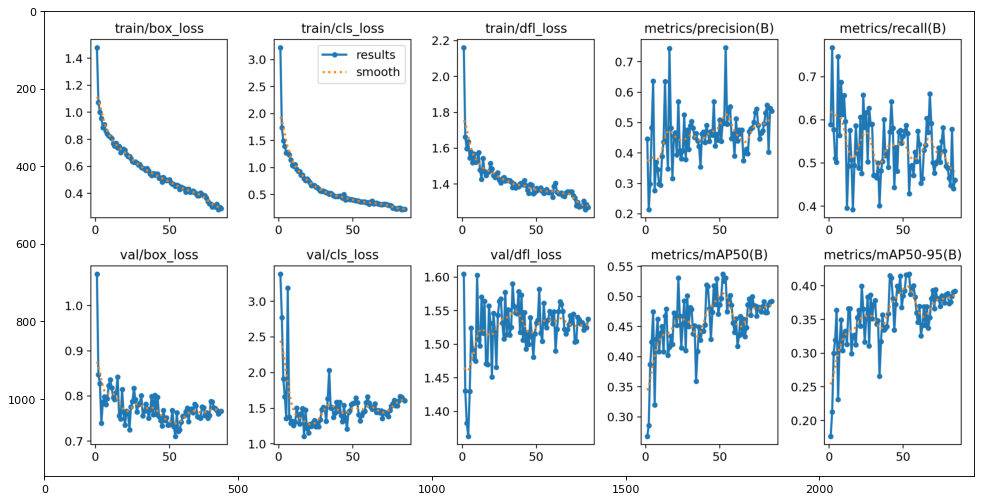

In [25]:
figure(figsize=(15, 10), dpi=80)
# reading the image
results = img.imread('runs/obb/train/results.png')
# displaying the image
plt.imshow(results)

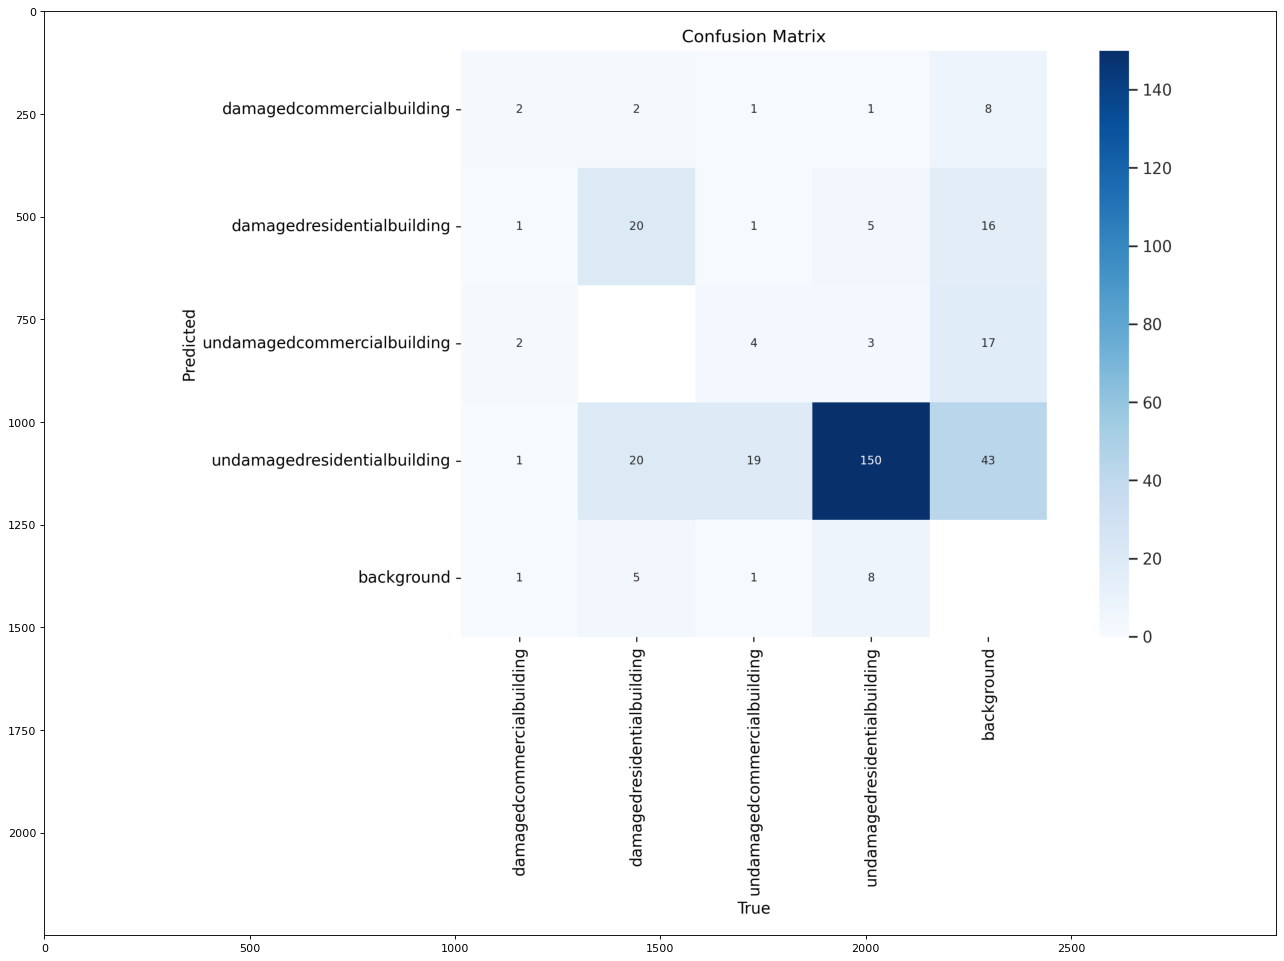

In [26]:
figure(figsize=(20,15), dpi=80)
# reading the image
cf = img.imread('runs/obb/train/confusion_matrix.png')
# displaying the image
plt.imshow(cf)

### Download submission images from platform

In [27]:
!gdown 1qfiywLvEEt1hd4w_2AdTKPVVwbnVWR-5

Downloading...
From: https://drive.google.com/uc?id=1qfiywLvEEt1hd4w_2AdTKPVVwbnVWR-5
To: /home/jovyan/challenge_1_submission_images.zip
100%|████████████████████████████████████████| 584k/584k [00:00<00:00, 43.1MB/s]


In [28]:
def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')



submission_zip = './challenge_1_submission_images.zip'
submission_directory = './challenge_1_submission_images'
unzip_folder(submission_zip,submission_directory)

The zip file ./challenge_1_submission_images.zip has been extracted to the directory ./challenge_1_submission_images


### Making Predictions on the Submission Data

First, we need to load the trained model using the best model weights obtained during training. This can be done using the YOLO class from the Ultralytics library.

In [29]:
# Load the Model
model = YOLO('runs/obb/train/weights/best.pt')

This command loads the trained model using the best model weights saved in the directory `runs/obb/train/weights/`.

In [30]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'damagedcommercialbuilding', 1: 'damagedresidentialbuilding', 2: 'undamagedcommercialbuilding', 3: 'undamagedresidentialbuilding'}
directory = 'challenge_1_submission_images/Submission data'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)

        for r in results:
            conf_list = r.obb.conf.cpu().numpy().tolist()
            clss_list = r.obb.cls.cpu().numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.obb.xyxy.cpu().numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


challenge_1_submission_images/Submission data/Validation_Post_Event_010.jpg
Making a prediction on  Validation_Post_Event_010.jpg

image 1/1 /home/jovyan/challenge_1_submission_images/Submission data/Validation_Post_Event_010.jpg: 640x640 39.3ms
Speed: 2.8ms preprocess, 39.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/obb/predict
1 label saved to runs/obb/predict/labels
Output files generated successfully.
challenge_1_submission_images/Submission data/Validation_Post_Event_008.jpg
Making a prediction on  Validation_Post_Event_008.jpg

image 1/1 /home/jovyan/challenge_1_submission_images/Submission data/Validation_Post_Event_008.jpg: 640x640 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/obb/predict
2 labels saved to runs/obb/predict/labels
Output files generated successfully.
challenge_1_submission_images/Submission data/Validation_Post_Event_006.jpg
Making a pred

This code generates a text file for each image in the input directory. Each file contains the object detection predictions in the format specified in the YAML file.

### Creating a ZIP File from a Directory
After completing the predictions on the shipping data and getting the results, we can package these results into a ZIP file to upload to the platform and verify the accuracy.
### Define the source directory and destination of the ZIP File

Before creating the ZIP file, we first need to define the source directory containing the results and the name and location of the ZIP file to be created.


In [31]:
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory Validation_Data_Results has been successfully zipped into submission.


This code packages all files and subdirectories of the source directory into a ZIP file at the specified location. The resulting ZIP file will have the same name as the value provided in `destination_zip` with the extension `.zip`.

Once the ZIP file has been created, it will be ready to submit to the platform and verify the accuracy of our model.

### Requirements

In [32]:
!pip freeze > requirements.txt